# Based on our custom MIMIC language model, train a 'DESCRIPTION' classifier

Make sure mimic_nlp_lm has been run first and sucessfully completed. That notebook builds the language model that allows classificiation to occur.

In [1]:
from fastai.text import *
from sklearn.model_selection import train_test_split
import glob
import gc

Setup filenames and paths

In [2]:
# pandas doesn't understand ~, so provide full path
base_path = Path.home() / 'mimic'

# files used during processing - all aggregated here
admissions_file = base_path/'ADMISSIONS.csv'
notes_file = base_path/'NOTEEVENTS.csv'

class_file = 'descr_cl_data.pickle'
notes_pickle_file = base_path/'noteevents.pickle'
lm_file = 'mimic_lm.pickle' # actual file is at base_path/lm_file but due to fastai function, have to pass file name separately
init_model_file = base_path/'descr_cl_head'
cycles_file = base_path/'descr_cl_num_iterations.pickle'
enc_file = 'mimic_fine_tuned_enc'
freeze_two = base_path/'descr_cl_freeze_two'
freeze_three = base_path/'descr_cl_freeze_three'
ft_file = 'descr_cl_fine_tuned_'

training_history_file = 'descr_cl_history'

Setup parameters for models

In [3]:
# original data set too large to work with in reasonable time due to limted GPU resources
pct_data_sample = 0.1
# how much to hold out for validation
valid_pct = 0.2
# for repeatability - different seed than used with language model
seed = 1776
# batch size of 96 GPU uses 15GB RAM
# batch size of 64 GPU uses 11GB RAM
# batch size of 48 GPU uses ??GB RAM
# changing batch size affects learning rate
bs=96

In [4]:
# if this doesn't free memory, can restart Python kernel.
# if that still doesn't work, try OS items mentioned here: https://docs.fast.ai/dev/gpu.html
def release_mem():
    gc.collect()
    torch.cuda.empty_cache()
release_mem()

In [5]:
orig_df = pd.DataFrame()
if os.path.isfile(notes_pickle_file):
    print('Loading noteevent pickle file')
    orig_df = pd.read_pickle(notes_pickle_file)
    print(orig_df.shape)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(notes_file, low_memory=False, memory_map=True)
    orig_df.to_pickle(notes_pickle_file)

Loading noteevent pickle file
(2083180, 11)


Since seed is different, this should be quite different than the language model dataset.

Should I show details on how many records are in language model dataset?

In [6]:
df = orig_df.sample(frac=pct_data_sample, random_state=seed)

In [7]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
1452901,1454539,14755,151669.0,2125-02-13,2125-02-13 05:37:00,2125-02-13 05:40:00,Nursing/other,Report,19585.0,NaN,Respiratory Care:\nPatient on PSV overnight of...
462929,466766,46041,176979.0,2160-06-02,2160-06-02 02:43:00,2160-06-02 02:57:32,Nursing,Nursing Progress Note,18654.0,NaN,"Shock, cardiogenic\n Assessment:\n Hemodyn..."
227661,237449,81883,118744.0,2143-10-28,NaN,NaN,ECG,Report,NaN,NaN,Compared to tracing #1 the patient's rate has ...
597361,603087,50450,147724.0,2191-09-20,2191-09-20 23:48:00,2191-09-20 23:48:27,Physician,Physician Attending Admission Note - MICU,16383.0,NaN,Chief Complaint: GI Bleed-melena and hemateme...
973311,962711,7287,108868.0,2152-06-02,2152-06-02 23:18:00,NaN,Radiology,PELVIS PORTABLE,NaN,NaN,[**2152-6-2**] 11:18 PM\n PELVIS PORTABLE ...


In [8]:
print('Unique Categories:', len(df.CATEGORY.unique()))
print('Unique Descriptions:', len(df.DESCRIPTION.unique()))

Unique Categories: 15
Unique Descriptions: 1708


In [9]:
# quote an imbalance between various DESCRIPTIONS
df.DESCRIPTION.value_counts()

Report                              113589
Nursing Progress Note                19169
CHEST (PORTABLE AP)                  17102
Physician Resident Progress Note      6311
CHEST (PA & LAT)                      4463
                                     ...  
R MR ARM W&W/O CONTRAST RIGHT            1
L MR THIGH W/O CONTRAST LEFT             1
R US MSK CYST (BAKERS) RIGHT             1
RNCM Initial Assessment                  1
Initial Assessment                       1
Name: DESCRIPTION, Length: 1708, dtype: int64

In [10]:
len(df.ROW_ID.unique())

208318

In [11]:
if os.path.isfile(base_path/lm_file):
    print('loading existing language model')
    lm = load_data(base_path, lm_file, bs=bs)
else:
    print('ERROR: language model file not found.')

loading existing language model


#### This is a very CPU and RAM intensive process - no GPU involved

Also, since there are a wide range of descriptions, not all descriptions present in the test set are in the validation set, so cannot learn all of them.

In [12]:
filename = base_path/class_file
if os.path.isfile(filename):
    data_cl = load_data(base_path, class_file, bs=bs)
    print('loaded existing data bunch')
else:
    # do I need a vocab here? test with and without...
    data_cl = (TextList.from_df(df, base_path, cols='TEXT', vocab=lm.vocab)
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=seed)
               #We randomly split and keep 20% for validation, set see for repeatability
               .label_from_df(cols='DESCRIPTION')
               #building classifier to automatically determine DESCRIPTION
               .databunch(bs=bs))
    data_cl.save(filename)
    print('created new data bunch')

loaded existing data bunch


### Using weighted F1 to account for class imbalance

See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [13]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


This rate will vary based on batch size. 

      For bs=96, 5e-2 worked well.
      For bs=48, looks like 1e-1 would work


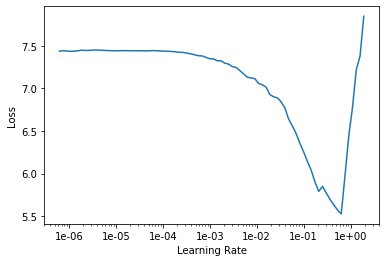

In [15]:
learn.recorder.plot()

## Now train model

Change learning rate based on results from the above plot

First unfrozen training results in approximately 90% accuracy with `learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))`

     epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time
        0 	0.508831 	0.406110 	0.907089 	0.888122 	18:41
        
By comparison, a smaller learning rate takes longer to get to similar accuracy (`learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))`)

    Total time: 25:38

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	0.451051 	0.413487 	0.909619 	25:38


### Evaluate some different learning rates:

```python
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)
learn.fit_one_cycle(1, 5e-1, moms=(0.8,0.7))
```

    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.670215	0.619886	0.888246	0.868050	19:47

```python
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))
```

    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.496811	0.436123	0.902583	0.884507	19:41

```python
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))
```

    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.505160	0.374866	0.911137	0.894657	26:27
        
        
```python
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))
```

    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.638841	0.539886	0.887017	0.861946	21:33

In [16]:
if os.path.isfile(str(init_model_file) + '.pth'):
    learn.load(init_model_file)
    print('loaded initial learner')
else:
    print('Training new initial learner')
    learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7),
                       callbacks=[
                           callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                       ])
    print('Saving new learner')
    learn.save(init_model_file)
    print('Finished generating new learner')

loaded initial learner


Now need to fine tune - try a few different learning rates for comparison

```python
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))
```

    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.328557	0.256304	0.949039	0.936714	25:59
        
```python
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
```

    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.394117	0.348810	0.922245	0.904277	24:41

Went with 5e-2

    Training new freeze_two learner
    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.349307	0.255599	0.947545	0.935599	22:15
    Saving new freeze_two learner
    Finished generating new freeze_two learner

In [17]:
os.path.isfile(str(freeze_two) + '.pth')
#str(freeze_two) + '.pth'
#os.path.isfile(str(freeze_three) + '.pth')
#    learn.load(freeze_two)
#    print('loaded freeze_two learner')

True

In [18]:
if os.path.isfile(str(base_path / freeze_two) + '.pth'):
    learn.load(freeze_two)
    print('loaded freeze_two learner')
else:
    print('Training new freeze_two learner')
    learn.freeze_to(-2)
    learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7),
                       callbacks=[
                           callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                       ])
    print('Saving new freeze_two learner')
    learn.save(freeze_two)
    print('Finished generating new freeze_two learner')

loaded freeze_two learner


Now compare a few different learning rates here as well

```python
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))
```

    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	1.433470	1.392961	0.752084	0.681817	27:45

```python
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
```

    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.326875	0.234437	0.952749	0.941585	28:56
        
Went with 1e-2 and got this result next time:

Training new freeze_three learner

    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.330733	0.249801	0.950749	0.938834	38:07
        
```python
learn.load(freeze_two)
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
```

    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.346814	0.245426	0.952026	0.940811	31:45

In [19]:
if os.path.isfile(str(freeze_three) + '.pth'):
    learn.load(freeze_three)
    print('loaded freeze_three learner')
else:
    print('Training new freeze_three learner')
    learn.freeze_to(-3)
    learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7),
                       callbacks=[
                           callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                       ])
    print('Saving new freeze_three learner')
    learn.save(freeze_three)
    print('Finished generating new freeze_three learner')

loaded freeze_three learner


In [20]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


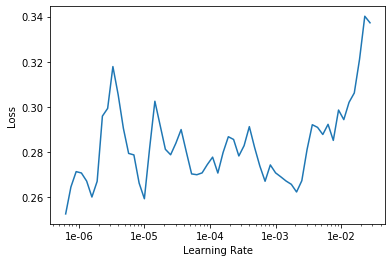

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
release_mem()

In [23]:
if os.path.isfile(cycles_file):
    with open(cycles_file, 'rb') as f:
        prev_cycles = pickle.load(f)
    print('This model has been trained for', prev_cycles, 'epochs already')  
else:
    prev_cycles = 0

    epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time
        0 	0.326372 	0.248257 	0.947810 	0.939235 	42:19
        1 	0.264299 	0.233219 	0.951448 	0.941490 	43:48
        2 	0.241548 	0.217816 	0.952870 	0.942942 	42:32
        3 	0.262864 	0.202371 	0.957014 	0.947445 	35:17
        4 	0.248916 	0.201936 	0.957111 	0.948590 	39:39
        
    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.329066	0.251686	0.951111	0.940551	43:34
        1	0.350617	0.238229	0.951376	0.940809	43:02
        2	0.328881	0.232468	0.950966	0.940160	39:15
        3	0.291664	0.220794	0.954918	0.944194	41:08
        4	0.271011	0.213012	0.955568	0.944835	48:17
        5	0.231853	0.207560	0.956412	0.945960	42:27
        6	0.211285	0.205632	0.957159	0.947107	42:27

In [24]:
num_cycles = 7

file = ft_file + str(prev_cycles)
learner_file = base_path/file
callback_save_file = str(learner_file) + '_auto'

learn.fit_one_cycle(num_cycles, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7),
                    callbacks=[
                        callbacks.SaveModelCallback(learn, every='epoch', monitor='accuracy', name=callback_save_file),
                        # CSVLogger only logs when num_cycles are complete
                        callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                    ])
file = ft_file + str(prev_cycles + num_cycles)
learner_file = base_path/file
learn.save(learner_file)

with open(cycles_file, 'wb') as f:
    pickle.dump(num_cycles + prev_cycles, f)
release_mem()

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.329066,0.251686,0.951111,0.940551,43:34
1,0.350617,0.238229,0.951376,0.940809,43:02
2,0.328881,0.232468,0.950966,0.940160,39:15
3,0.291664,0.220794,0.954918,0.944194,41:08
4,0.271011,0.213012,0.955568,0.944835,48:17
5,0.231853,0.207560,0.956412,0.945960,42:27
6,0.211285,0.205632,0.957159,0.947107,42:27
